In [22]:
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [23]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [24]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [25]:
training_data = np.load("training_data.npy").astype(np.float32)
categories = np.load("categories.npy")
valid_periods=np.load("valid_periods.npy")
categories_unique = np.unique(categories)

print(training_data.shape)
print(valid_periods.shape)
print(categories.shape)

(48000, 2776)
(48000, 2)
(48000,)


In [26]:
window_length=100
telescope=18

In [27]:
def build_dataset(category, window_length=200, telescope=18, from_start=True):
    dataset = []

    skipped_samples = 0
    dataset_window_length = window_length + telescope
    sample_map = categories==category
    
    valid_perios_for_category = valid_periods[sample_map]
    training_data_for_category = training_data[sample_map]

    for i in range(len(valid_perios_for_category)):
        from_time = valid_perios_for_category[i,0]
        to_time = valid_perios_for_category[i,1]
        if(to_time-from_time<dataset_window_length):
            skipped_samples+=1
            continue
        if(from_start):
            sample = training_data_for_category[i][from_time:from_time+dataset_window_length]
        else:
            sample = training_data_for_category[i][to_time-dataset_window_length:to_time]
        dataset.append(sample)

    dataset = np.array(dataset)
    dataset = dataset.reshape((dataset.shape[0], dataset.shape[1], 1))
    print("Skipped samples: ", skipped_samples)

    return dataset

In [28]:
dataset_A = build_dataset("A", window_length=window_length, telescope=telescope)
dataset_A.shape

Skipped samples:  168


(5560, 118, 1)

In [29]:
def plot_data_samples(data, lables):
    plt.figure(figsize=(20,10))
    c_uniques = np.unique(lables)
    for i in range(len(c_uniques)):
        category_data = data[lables==c_uniques[i],:]
        plt.plot(category_data[np.random.randint(0, category_data.shape[0]),:])
    plt.legend(c_uniques)
    plt.show()

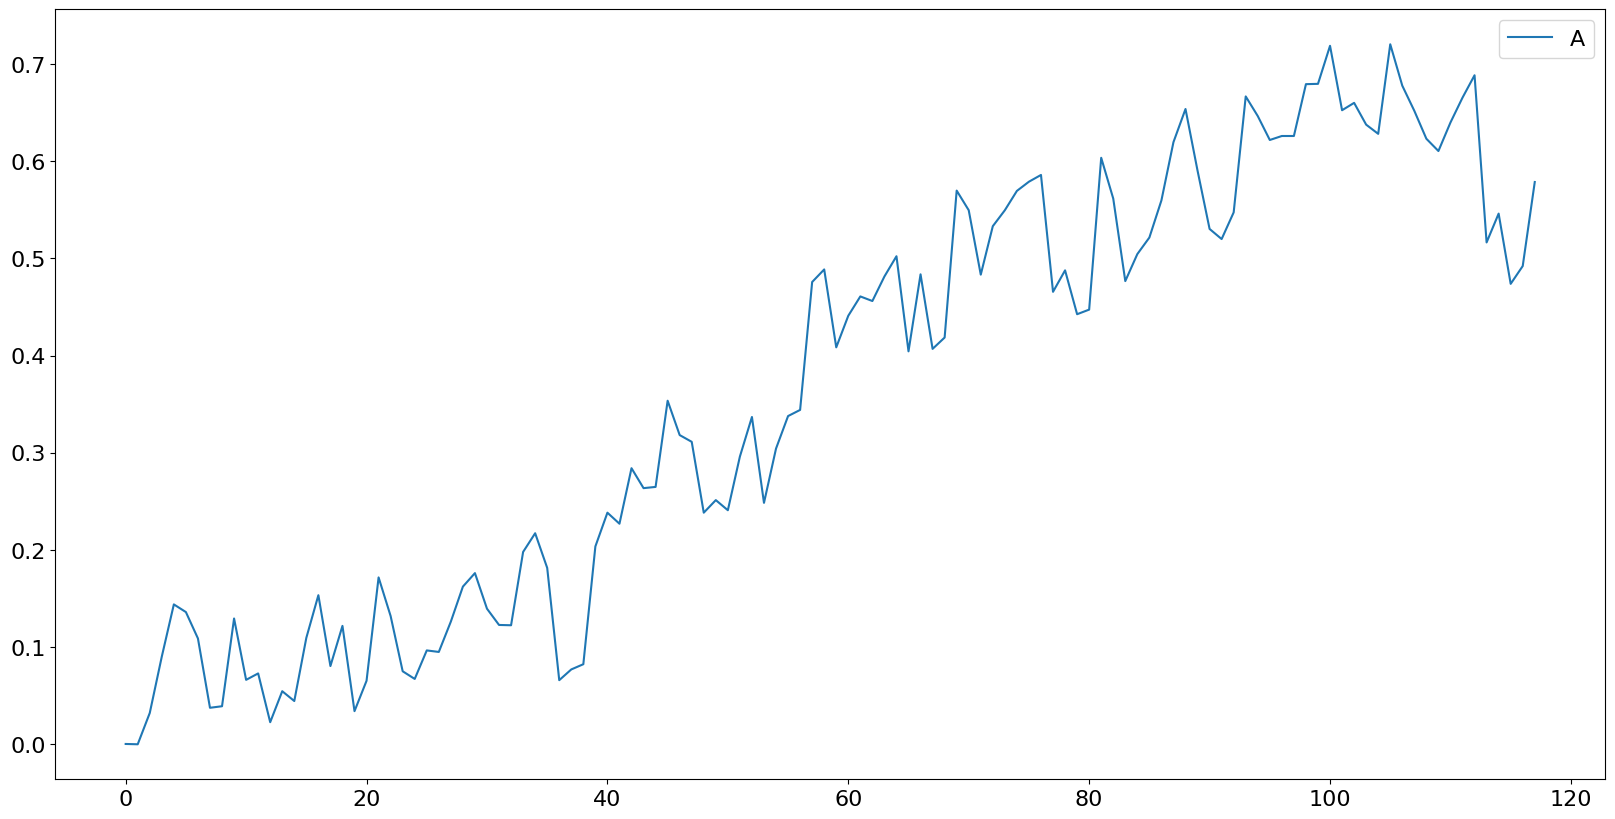

In [30]:
plot_data_samples(dataset_A, np.array(["A"]*dataset_A.shape[0]))

In [31]:
X_train_raw, X_test_raw = train_test_split(dataset_A, random_state=seed, test_size=0.2)
X_train_raw.shape, X_test_raw.shape

((4448, 118, 1), (1112, 118, 1))

In [32]:
X_train, y_train = X_train_raw[:, :-telescope], X_train_raw[:, -telescope:]
X_test, y_test = X_test_raw[:, :-telescope], X_test_raw[:, -telescope:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4448, 100, 1), (4448, 18, 1), (1112, 100, 1), (1112, 18, 1))

In [33]:
def inspect_x_y(X, y, telescope):
    index = np.random.randint(0, X.shape[0])
    plt.plot(np.arange(len(X[index,:])), X[index,:])
    plt.scatter(np.arange(len(X[index,:]), len(X[index,:])+telescope), y[index,:], color='orange')
    plt.show()

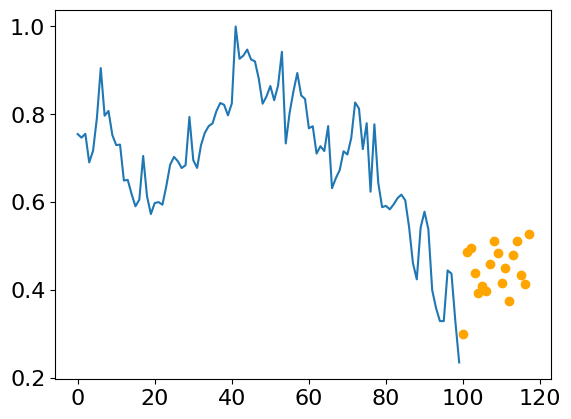

In [34]:
inspect_x_y(X_train, y_train, telescope)

In [35]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [36]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics=['mse', "mae"])

    return model

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 100, 1)]          0         
                                                                 
 bidirectional_lstm (Bidire  (None, 100, 128)          33792     
 ctional)                                                        
                                                                 
 conv (Conv1D)               (None, 100, 128)          49280     
                                                                 
 output_layer (Conv1D)       (None, 100, 1)            385       
                                                                 
 cropping (Cropping1D)       (None, 18, 1)             0         
                                                                 
Total params: 83457 (326.00 KB)
Trainable params: 83457 (326.00 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

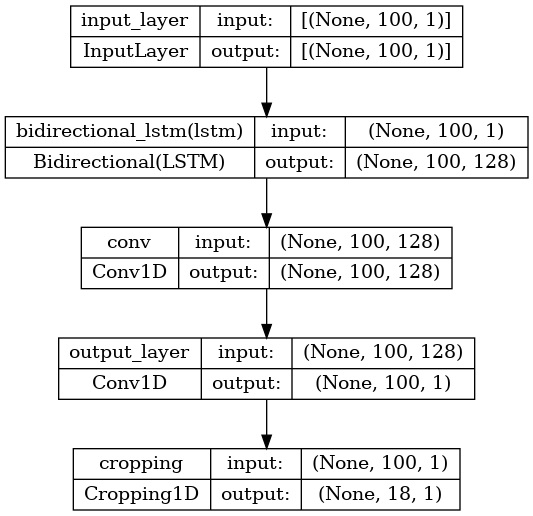

In [37]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [38]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
63/63 [==============================] - 5s 29ms/step - loss: 0.0692 - mse: 0.0692 - mae: 0.2093 - val_loss: 0.0436 - val_mse: 0.0436 - val_mae: 0.1682 - lr: 0.0010
Epoch 2/200
63/63 [==============================] - 1s 20ms/step - loss: 0.0486 - mse: 0.0486 - mae: 0.1792 - val_loss: 0.0397 - val_mse: 0.0397 - val_mae: 0.1597 - lr: 0.0010
Epoch 3/200
63/63 [==============================] - 1s 20ms/step - loss: 0.0381 - mse: 0.0381 - mae: 0.1526 - val_loss: 0.0259 - val_mse: 0.0259 - val_mae: 0.1254 - lr: 0.0010
Epoch 4/200
63/63 [==============================] - 1s 20ms/step - loss: 0.0285 - mse: 0.0285 - mae: 0.1308 - val_loss: 0.0225 - val_mse: 0.0225 - val_mae: 0.1152 - lr: 0.0010
Epoch 5/200
63/63 [==============================] - 1s 20ms/step - loss: 0.0256 - mse: 0.0256 - mae: 0.1229 - val_loss: 0.0249 - val_mse: 0.0249 - val_mae: 0.1233 - lr: 0.0010
Epoch 6/200
63/63 [==============================] - 1s 20ms/step - loss: 0.0253 - mse: 0.0253 - mae: 0.1224 - val_

In [39]:
autoregressive_model = tfk.models.load_model("AuroregressiveForecasting")

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 100, 3)]          0         
                                                                 
 bidirectional_lstm (Bidire  (None, 100, 128)          34816     
 ctional)                                                        
                                                                 
 conv (Conv1D)               (None, 100, 128)          49280     
                                                                 
 output_layer (Conv1D)       (None, 100, 3)            1155      
                                                                 
 cropping (Cropping1D)       (None, 10, 3)             0         
                                                                 
Total params: 85251 (333.01 KB)
Trainable params: 85251 (333.01 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

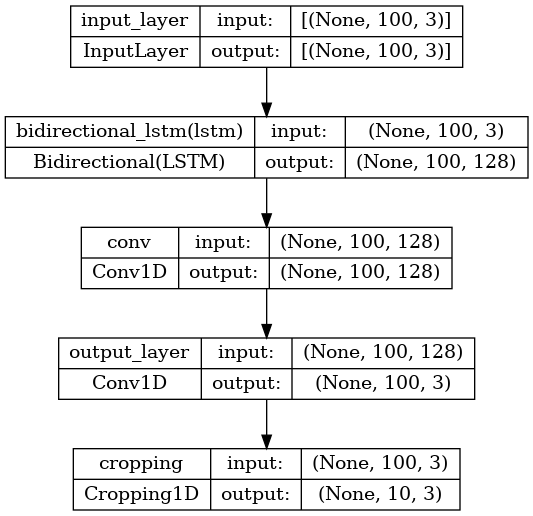

In [40]:
autoregressive_model.summary()
tfk.utils.plot_model(autoregressive_model, expand_nested=True, show_shapes=True)

0.01598258689045906